# Seq2seq with attention 을 이용한 한영 기계번역 
* google colab 환경에서 실행
* 기존의 영어-스페인어 Seq2seq with attention 모델을 차용하여, 한글과 영어 사이에서도 attention을 이용한 기계번역모델 구현이 가능한지 탐색
* 데이터 : 모델의 성능을 높이기 위해 AI Hub에서 제공하는 한글-영어 구어체 말뭉치 데이터 20만 개 중 5만개 사용
* 참고 : https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 한글 글꼴 설정
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

In [3]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
!pip install sentencepiece
from sentencepiece import *

import unicodedata
import re
import numpy as np
import pandas as pd
import os
import io
import time
from tqdm import tqdm

import collections

     |████████████████████████████████| 1.1MB 16.3MB/s 


# Prepare txt data

In [4]:
def preprocess_sentence(w):
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    try:
      w = w.lower().strip()
      w = re.sub(r"([?.!,¿])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)

      # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
      w = re.sub(r"[^a-zA-Z0-9가-힣?.!,¿]+", " ", w)

      w = w.strip()

      # adding a start and an end token to the sentence
      # so that the model know when to start and stop predicting.
      w = '<start> ' + w + ' <end>'
    except:
      w = re.sub(r"([?.!,¿])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)

      # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
      w = re.sub(r"[^a-zA-Z0-9가-힣?.!,¿]+", " ", w)

      w = w.strip()

      # adding a start and an end token to the sentence
      # so that the model know when to start and stop predicting.
      w = '<start> ' + w + ' <end>'
    return w

In [5]:
path = '/content/drive/MyDrive/딥러닝기말/1_구어체(1)_200226.xlsx'

In [6]:
def create_dataset(path, num_examples):
  #en_ko.txt 열 때
  #lines = io.open(path, encoding='cp949').read().strip().split('\n')[1:-1]
  # word_pairs = [[preprocess_sentence(re.sub('\"\)\,','',w)) for w in l.split('\", "')]  for l in lines[:num_examples]]
  data = pd.read_excel(path)
  data = data.sample(frac=1).reset_index(drop=True)[:num_examples]
  word_pairs = [[preprocess_sentence(e),preprocess_sentence(k)]  for index, (k,e) in enumerate(zip(data['원문'],data['번역문']))]

  return zip(*word_pairs)

In [7]:
en, ko = create_dataset(path,50000)

In [8]:
print(en[2999])
print(ko[2999])

<start> i m sorry , but i m busy . <end>
<start> 미안하지만 난 지금 바빠요 . <end>


# Tokenize & padding
* tokenizer : SentencePiece tokenizer 사용

In [9]:
with open('target_sentences.txt', 'w', encoding='utf-8') as f:
    for sent in ko:
        f.write('{}\n'.format(sent))

In [10]:
with open('source_sentences.txt', 'w', encoding='utf-8') as f:
    for sent in en:
        f.write('{}\n'.format(sent))

In [11]:
input_arg = '--input=source_sentences.txt --model_prefix=source --pad_id=0 --pad_piece=<pad> --unk_id=1 --unk_piece=<unk> --bos_piece=<start> --bos_id=2 --eos_piece=<end> --eos_id=3 --user_defined_symbols=<start>,<end> --vocab_size=20000 --hard_vocab_limit=false'
SentencePieceTrainer.train(input_arg)
sp_s = SentencePieceProcessor()
sp_s.Load('source.model')

output_arg = '--input=target_sentences.txt --model_prefix=target --pad_id=0 --pad_piece=<pad> --unk_id=1 --unk_piece=<unk> --bos_piece=<start> --bos_id=2 --eos_piece=<end> --eos_id=3 --user_defined_symbols=<start>,<end> --vocab_size=20000 --hard_vocab_limit=false'
SentencePieceTrainer.Train(output_arg)
sp_t = SentencePieceProcessor()
sp_t.Load('target.model')


input_tensor = [sp_s.encode_as_ids(lg)[1:] for lg in en]
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor,padding='post')

target_tensor = [sp_t.encode_as_ids(lg)[1:] for lg in ko]
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor,padding='post')

In [12]:
input_tensor

array([[  2,  25,  34, ...,   0,   0,   0],
       [  2,  83,  16, ...,   0,   0,   0],
       [  2,  69,  10, ...,   0,   0,   0],
       ...,
       [  2,   6, 247, ...,   0,   0,   0],
       [  2,   8,  50, ...,   0,   0,   0],
       [  2,  18, 340, ...,   0,   0,   0]], dtype=int32)

In [13]:
with open('source.vocab', encoding='utf-8') as f:
    Vi = [doc.strip().split("\t") for doc in f]
    
with open('target.vocab', encoding='utf-8') as f:
    Vo = [doc.strip().split("\t") for doc in f]

# w[0]: token name    
# w[1]: token score
word2idx_i = {w[0]: i for i, w in enumerate(Vi)}
word2idx_o = {w[0]: i for i, w in enumerate(Vo)}

idx2word_i = {i : w[0] for i, w in enumerate(Vi)}
idx2word_o = {i : w[0] for i, w in enumerate(Vo)}

In [14]:
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [15]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

40000 40000 10000 10000


In [16]:
def convert_source(tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, idx2word_i[t]))

def convert_target(tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, idx2word_o[t]))

In [17]:
print ("Input Language; index to word mapping")
print(convert_source(input_tensor[1989]))
print ("\n Target Language; index to word mapping")
print(convert_target(target_tensor[1989]))

Input Language; index to word mapping
2 ----> <start>
63 ----> ▁he
315 ----> ▁came
15 ----> ▁of
888 ----> ▁age
4 ----> ▁
5 ----> .
4 ----> ▁
3 ----> <end>
None

 Target Language; index to word mapping
2 ----> <start>
25 ----> ▁그
8 ----> 는
234 ----> ▁이제
12208 ----> ▁성년
13 ----> 이
1029 ----> ▁되었어
7 ----> 요
4 ----> ▁
5 ----> .
4 ----> ▁
3 ----> <end>
None


# Create a tf.data dataset

In [18]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 512
units = 1024
vocab_inp_size = len(word2idx_i)+1
vocab_tar_size = len(word2idx_o)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [19]:
steps_per_epoch

625

In [20]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 62]), TensorShape([64, 53]))

In [21]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') #Decoder의 initial state 사용

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state
    
    # encoder의 hidden state을 초기화
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [22]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 62, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # values : hidden state(encoder의 output)
    # query : decoder의 hidden state
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(hidden_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [24]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 62, 1)


In [25]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    
    # used for attention
    self.attention = BahdanauAttention(self.dec_units)
        
  def call(self, x, hidden, enc_output): 
    #enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x) # x : decoder에 input되는 word

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x) #이전 step의 hidden state

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [26]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 20001)


# Define the optimizer and the loss function

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) #padding 부분 없앰
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [28]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([word2idx_o['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

# Train

In [29]:
dataset

<BatchDataset shapes: ((64, 62), (64, 53)), types: (tf.int32, tf.int32)>

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [31]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.0541
Epoch 1 Batch 100 Loss 1.7984
Epoch 1 Batch 200 Loss 1.4862
Epoch 1 Batch 300 Loss 1.4912
Epoch 1 Batch 400 Loss 1.4210
Epoch 1 Batch 500 Loss 1.4342
Epoch 1 Batch 600 Loss 1.5240
Epoch 1 Loss 1.6276
Time taken for 1 epoch 590.8694491386414 sec

Epoch 2 Batch 0 Loss 1.4317
Epoch 2 Batch 100 Loss 1.5679
Epoch 2 Batch 200 Loss 1.3128
Epoch 2 Batch 300 Loss 1.3164
Epoch 2 Batch 400 Loss 1.4041
Epoch 2 Batch 500 Loss 1.2004
Epoch 2 Batch 600 Loss 1.5608
Epoch 2 Loss 1.3621
Time taken for 1 epoch 545.9823062419891 sec

Epoch 3 Batch 0 Loss 1.2687
Epoch 3 Batch 100 Loss 1.3771
Epoch 3 Batch 200 Loss 1.2265
Epoch 3 Batch 300 Loss 1.3366
Epoch 3 Batch 400 Loss 1.1338
Epoch 3 Batch 500 Loss 1.2362
Epoch 3 Batch 600 Loss 1.2727
Epoch 3 Loss 1.2378
Time taken for 1 epoch 547.6883497238159 sec

Epoch 4 Batch 0 Loss 1.0548
Epoch 4 Batch 100 Loss 1.2241
Epoch 4 Batch 200 Loss 1.1942
Epoch 4 Batch 300 Loss 1.0109
Epoch 4 Batch 400 Loss 1.2600
Epoch 4 Batch 500 Loss 1.1299


# Evaluate

In [32]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [sp_s.encode_as_ids(sentence)[1:]]
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = []

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([word2idx_o['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result.append(int(predicted_id))

    if predicted_id == 3:
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [33]:
import matplotlib.pyplot as plt
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [34]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    result = sp_t.DecodeIds(result)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}\n'.format(result))

    #attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    #plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [42]:
def translate_plot(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    result = sp_t.DecodeIds(result)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}\n'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [43]:
for i in range(100):
  translate(sp_s.DecodeIds(input_tensor_val[i].tolist()).replace('<start>','').replace('<end>','').replace(' . ','.').strip())

Input: <start> there are lots of benefits to a smartphone like this . <end>
Predicted translation: 이는 이 세상에는 많은 종류의 특징이 있어요 . <end>

Input: <start> can you have my haircut done by four o clock ? <end>
Predicted translation: 내가 제가 브리즈번에 자전거를 잘라 주실 수 있어 ? <end>

Input: <start> it isn t still proceeding even though i answered all the required questions in the press release form and paid for everything by using ethereum . <end>
Predicted translation: 보도자료를 해결하기 때문에 확인해서는 해당 eac 사용한 문제를 할 수 없기 때문에 처음으로 진행되었는데 계속해서는 해당 eac 사용한 문제를 할 수 없기 때문에 처음으로 진행되었는데 계속해서는 해당 eac 사용한 문제를 할 수

Input: <start> and now i can go in the water without being afraid and have fun <end>
Predicted translation: 그리고 지금은 먹을 수 있어 . <end>

Input: <start> this is very slimy . <end>
Predicted translation: 이것은 정말 똑똑한 반지입니다 . <end>

Input: <start> i practiced really hard but i couldn t pronounce it well . <end>
Predicted translation: 나는 너무 아파서 탓할 수 없었습니다 . <end>

Input: <start> doesn t the supervisor mind if we listen to the 

In [44]:
for i in range(100):
  translate(sp_s.DecodeIds(input_tensor_val[i].tolist()).replace('<start>','').replace('<end>','').replace(' . ','.').strip())

Input: <start> when did humans start to use tools for the first time ? <end>
Predicted translation: 다음과 같은 이유로 고용을 받은 건가요 ? <end>

Input: <start> no matter what happens , please keep your beautiful smile . <end>
Predicted translation: 아무리울 때도 좋아지지 마세요 . <end>

Input: <start> there is a student recovering through this process . <end>
Predicted translation: 이 문제를 통해 한 번도 있습니다 . <end>

Input: <start> so i was sorry . <end>
Predicted translation: 그래서 난 그랬었던 거야 . <end>

Input: <start> yes , i am in korea now , and another person got to the office to correct it . <end>
Predicted translation: 응 , 지금 지금 한국에 와서 지금은 정말 잘 하고 있습니다 . <end>

Input: <start> working with people who understand my personal characteristics , i am also learning how to work with others , to recognize them , to respect each other , to work with them . <end>
Predicted translation: 공부를 하고 싶습니다 . <end>

Input: <start> which team are you in ? <end>
Predicted translation: 너는 대체 소속이 있어 ? <end>

Input: <start> don t worry , i know

Input: <start> i m thinking of putting my house on sale . <end>
Predicted translation: 우리 집을 팔려고 내놓을까 생각 중이에요 . <end>



/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50864 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51665 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51012 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47140 missing from current font.
  font.set_

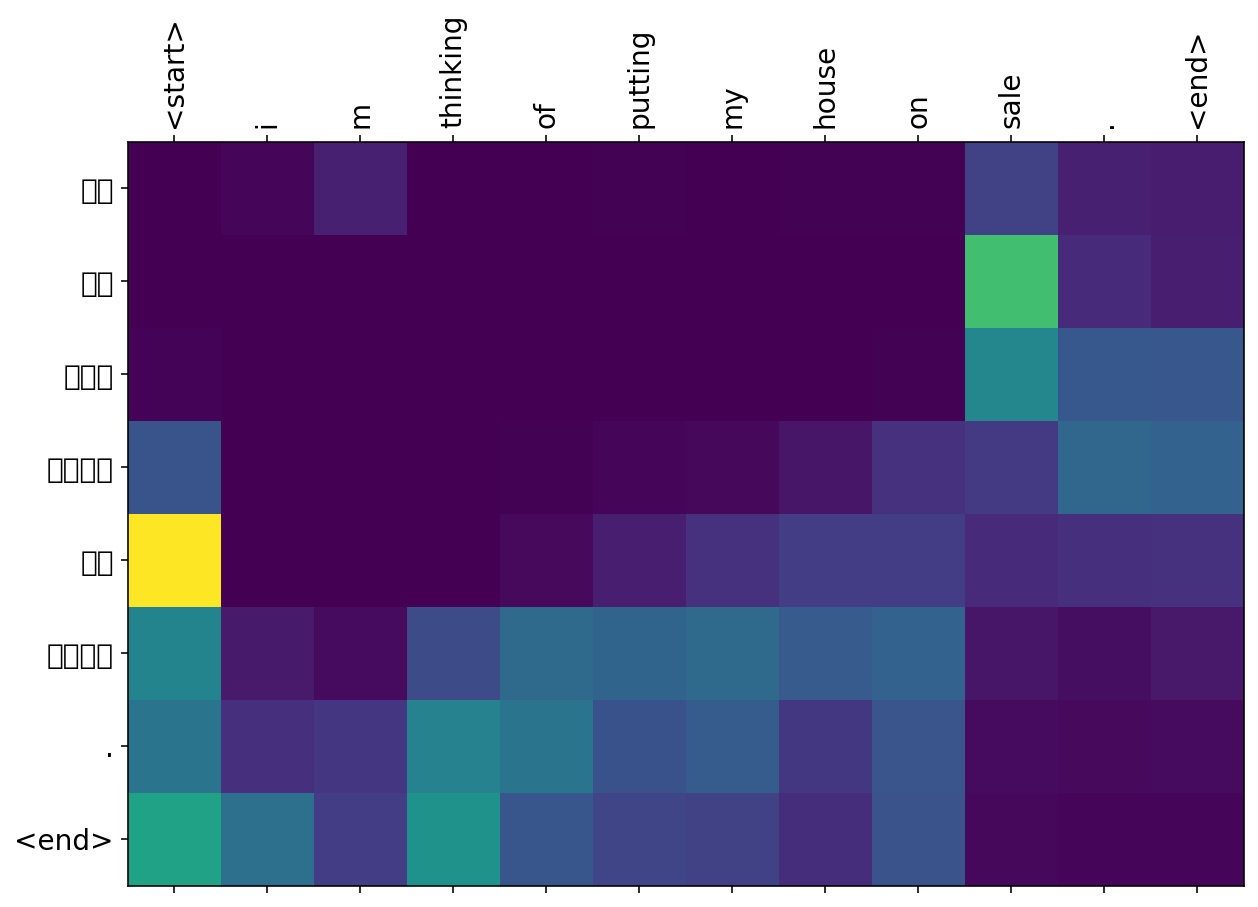

In [50]:
translate_plot('i m thinking of putting my house on sale.')

Input: <start> i lost my luggage in rome . <end>
Predicted translation: 저는 동호회에 있는 향수를 배웅했습니다 . <end>



/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46041 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_

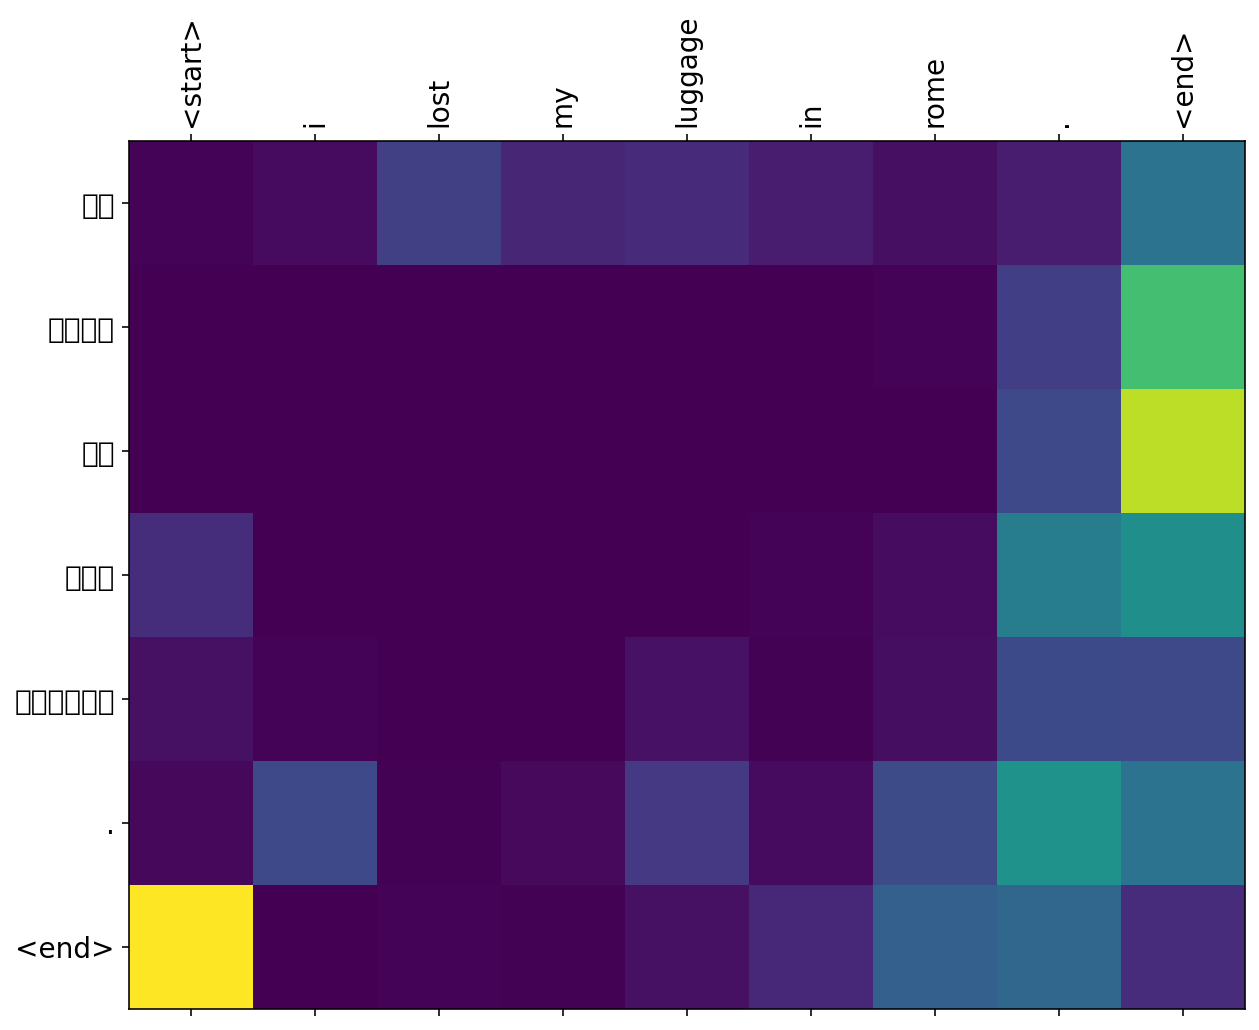

In [46]:
translate_plot('I lost my luggage in Rome.')

# BLEU score

In [38]:
from nltk.translate.bleu_score import *
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method0
# sentence BLEU score
cal_val = []
for i in range(300):
  candidate = sp_t.id_to_piece(evaluate(sp_s.DecodeIds(input_tensor_val[i].tolist()).replace('<start>','').replace('<end>','').replace(' . ','.').strip())[0])
  reference = sp_t.encode_as_pieces(sp_t.DecodeIds(target_tensor_val[i].tolist()).replace('<start>','').replace('<end>','').replace(' . ','.').strip())
  a = sentence_bleu(reference, candidate, smoothing_function=smoothie)
  cal_val.append(a)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [39]:
smoothie = SmoothingFunction().method0
# sentence BLEU score
cal_train = []
for i in range(300):
  candidate = sp_t.id_to_piece(evaluate(sp_s.DecodeIds(input_tensor_train[i].tolist()).replace('<start>','').replace('<end>','').replace(' . ','.').strip())[0])
  reference = sp_t.encode_as_pieces(sp_t.DecodeIds(target_tensor_train[i].tolist()).replace('<start>','').replace('<end>','').replace(' . ','.').strip())
  a = sentence_bleu(reference, candidate, smoothing_function=smoothie)
  cal_train.append(a)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [40]:
np.median(cal_train)

0.668740304976422

In [41]:
np.median(cal_val)

0.668740304976422

In [47]:
np.mean(cal_train)

0.6198837653219061

In [48]:
np.mean(cal_val)

0.6381832365401651